## Image segmentation with CamVid

**Segmentation** means classification for every single pixel in a pic. 

To build a segmentation model, you would need a dataset where someone has actually labelled every pixel: a lot of work! Probably you are noit going to do it yourself! Very common in medicine, life sciences, automotive, etc. many domain areas in which domain-specific tools exist. We can use a nice dataset, in which a lot os segmented images are available.

ALl details about datasets at: course.fast.ai. You should QUOTE article/people for this!


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Next cell will download all stuff into:

    [PosixPath('/Users/bonacor/.fastai/data/camvid/images'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/labels'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/codes.txt'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/valid.txt')]

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/Users/bonacor/.fastai/data/camvid/images'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/labels'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/codes.txt'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/Users/bonacor/.fastai/data/camvid/images/0001TP_009030.png'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/images/0001TP_008460.png'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/images/0016E5_08490.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/Users/bonacor/.fastai/data/camvid/labels/Seq05VD_f04560_P.png'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/labels/0001TP_009630_P.png'),
 PosixPath('/Users/bonacor/.fastai/data/camvid/labels/0016E5_08117_P.png')]

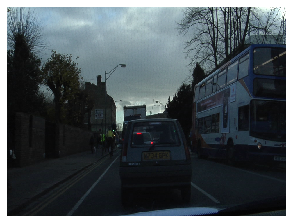

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

Probably the names have a `_P` at the end when they are labels? Just gettins.. let's write a lamdba to handle this;

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

You need to use `open_mask` and not `open_img` here, if you want to see ther masking. Note that `.show` will recognize it is a mask, and will associate random colours to each area. Note also that this all masking deals with integers, not floating point. 

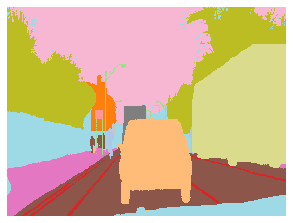

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

We have the segmentation as numbers, the same for the same 'logical' area.

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[30, 30, 30,  ..., 21, 21, 21],
          [30, 30, 30,  ..., 21, 21, 21],
          [30, 30, 30,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

Note they gaves us:

    [PosixPath('/Users/bonacor/.fastai/data/camvid/images'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/labels'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/codes.txt'),
     PosixPath('/Users/bonacor/.fastai/data/camvid/valid.txt')]

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

Quite selfexplanatory: take a nb in the tensor, count on the codes and find what that nb refers to (e.g. building, or street, etc).

## Datasets

Time to handle the problem as usual, i.e. create a DataBunch appropriately, etc:

Original image size was divided by 2. More later on this..

In [13]:
size = src_size//2       # integer divide

In [14]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


There seems to be more than one way to do this today on pytorch.

**WARNING  FIXME this does not work**

In [15]:
# NO

# src = (ImageFileList.from_folder(path_img)
#        .label_from_func(get_y_fn)
#        .split_by_fname_file('../valid.txt'))

NameError: name 'ImageFileList' is not defined

Explanation might be here:
    https://forums.fast.ai/t/name-imagefilelist-is-not-defined-in-fastai-version-1-0-24/30463, but that does not work either. This is what wa

In [ ]:
# NO

# src = (ImageItemList.from_folder(path_img)
#        .label_from_func(get_y_fn)
#        .split_by_fname_file('../valid.txt'))

(go with what's below this point)

Probably they gave us valid.txt so that we do not so it randomly, otherwise we might end up in having pixels close to each other and then it is too easy (FIXME). Also, usually we have string labels, here we do not, and we have to use `classes=codes` to get the labels from a file (the list of what the nbs in the tensor mean).

In [16]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

Specifying `tfm_y=True`, we are telling to trasform also the `y` when we transform the `x`, otherwise flipping a pic and NOT flippin its segmented pic will result in them not matching anymore, i.e. you need to flip both.

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs,
                   num_workers=0)       # added num_workers=0 (remember it goes where databunch is defined, and close to bs)
        .normalize(imagenet_stats))

Fast.ai understands that this is a segmentation model you are building, and when you ask for a `.show_batch` it colour-codes the images! This is makes way easier to check the ground-truth.

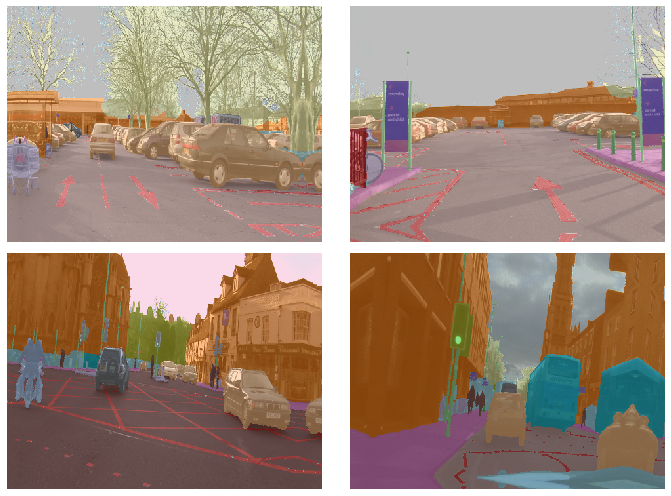

In [18]:
data.show_batch(2, figsize=(10,7))

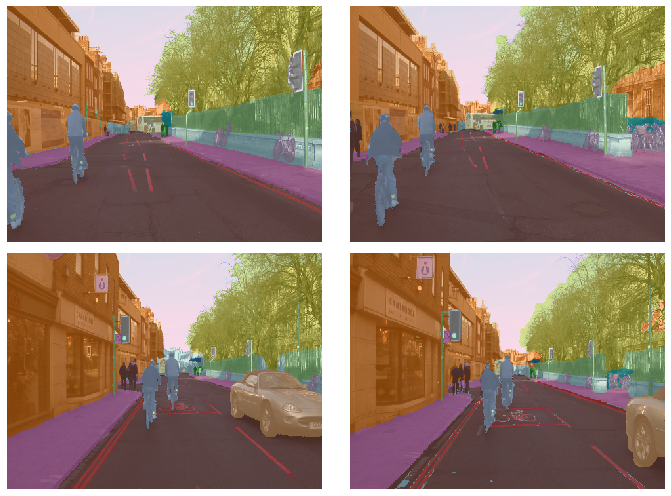

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

---

**This should go somewhere but not here**. Tloss > Vloss means you are definitely underfitting. Cure: train for longer, train the last bit on a lower lr, but if you still underfit you need to deep freeze regularization. We will talk about it.

---

## Model

We needo create a new accuracy metric. This because when they label the pixel, sometimes they label pixels as `Void` (a mistake? somehting unknoown?). You should remove the Void picture when you report accuracy. 

`input` is the output of the NN. `target` is tha label you are trying to predict. We create a `mask` by looking to when `target` is not equal to void. Then  we return the input after a standard accuracy `argmax`, then we grab those not equal to the void code, we do the same for the `target` and we take the mean. It is basically the same code for the accuracy we saw before with the addition of this void masking.


In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics=acc_camvid
# metrics=accuracy

In [22]:
wd=1e-2

For a segmentation model, we do NOT use a CNN but Unet. 
- check the url on keynote FIXME

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time


In [ ]:
lr=3e-3

In [ ]:
# FIXME non so se qui ha gia' senso..
learn.recorder.plot_losses()

In [ ]:
# FIXME non so se qui ha gia' senso..
learn.recorder.plot_lr()

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

If you run `learn.recorder.plot_losses()` it plots the Tloaa and Vloss. You will see both going up for a while and then down. Why? Plot also the `learn.recorder.plot_lr()`, and you will see it doing the same, up and then down. This is because we used fit_one_cycle, and this is what it does: it makes the lr start low, go up and then go down again. 

Why is it a good idea? (FIXME animation, 1h20 of lect3)

Because starting quickly saves you time, but then at the end slowing down helps you not to jump off bumps where your minimum resides, so that you converge eventually. The idea of slowing down at the end is around since ages, and it is called **learning rate annealing**. The idea to strat quickly is due to a guy called Leslie Smith: if you grasually increase the lr, what tends to happen is that you may end up initially in the bottom of a bumpy area, but you can bounce off that bottom of a bumpy areas when the lr gradually increases, so you do not stay there (where the solution will tend not to generalize well, as it is good in that place but not very good in all other places), but you have a chance to move out and do a better job. It is a good way to explore all the space of the function and find minima. 

So, if you see the plots are described ago, it is a good sign.



In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-2');

**SUGGESTION**. Type `learn.recorder.`<kbd>TAB</kbd> and `learn.recorder.plot`<kbd>TAB</kbd>

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

Before it was:

In [ ]:
# size = src_size//2       # integer divide

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

Now we do:

In [ ]:
learn.destroy()

In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

The idea is that NOW you go big and try full-size images, and as a consequence you might run out of RAM on the GPU, so you decrease bs. FIXME in the lecture it was going with full size and bs=4 explicitly.

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

For mem issues, best is to destroy the learner, create a new one, and load where you saved last. This means that:
- the learner will have the same weights as of when we plotted the curves before...
- ... while the data now has full size.

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

And now you gto as before.

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

FIXME le opzioni sono  un po- diverse, e.g. compare questpo wd che non ho capito.

The claim is that the best paper (FIXME see keynote) states best world result on segmentation is 91.5 accuracy, and here we get >92%. What?! The claim is that on previous ciourse they spend a lot of time with the tiramisu, and with latest fastai classes yoiu get better than best world result! (and the training time at that time was hrs, now it has been minutes).

### Mixed precision learning

If you add `.to_fp16` at the end of each Learner call, instead of using single precision floating point nbs, you can us half-precision fp nbs in most of the calculation in your models (i.e. 16 bits instead of 32 bits). Note you need to have the most recent CUDA drivers, etc. It uses less GPU RAM, and it will go faster too. Try it out, lectures found a larger accuracy even! (in addition to be faster, and using bigger figs bunches, etc)



## fin